In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

train = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/val",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [19]:
class_names = train.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [4]:
for image_batch, labels_batch in train.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[5 0 0 2 3 6 6 4 6 4 0 3 4 0 1 5 7 5 2 8 3 6 8 3 2 4 0 7 8 6 1 5]


## Visualization

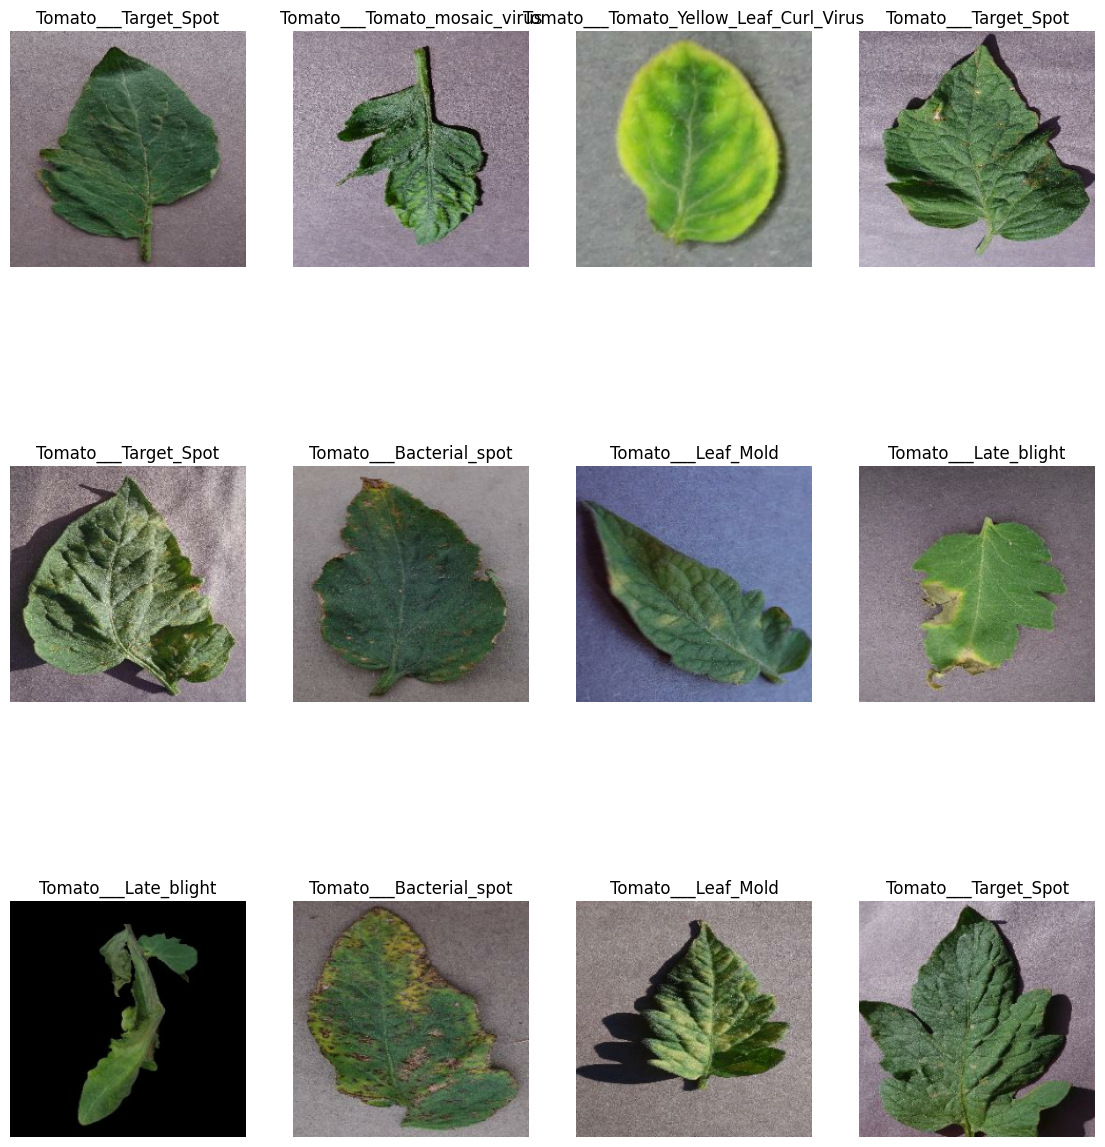

In [5]:
plt.figure(figsize=(14, 16))
for image_batch, labels_batch in train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
len(train)

313

## train test split

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.95,test_split=0.05, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size)
    
    return train_ds, test_ds

In [4]:
train_ds,test_ds = get_dataset_partitions_tf(train)

In [5]:
print(len(train_ds))
print(len(test_ds))

297
16


## prefetch and cache

In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Rescaling and Augmentation

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [9]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored quantity
)

In [13]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=50,
    #callbacks=[early_stopping]
)

Epoch 1/50
297/297 [==============================] - 87s 208ms/step - loss: 2.0461 - accuracy: 0.2353 - val_loss: 2.2324 - val_accuracy: 0.3790
Epoch 2/50
297/297 [==============================] - 61s 205ms/step - loss: 1.5736 - accuracy: 0.4765 - val_loss: 2.3851 - val_accuracy: 0.3750
Epoch 3/50
297/297 [==============================] - 61s 204ms/step - loss: 1.3291 - accuracy: 0.5675 - val_loss: 2.3871 - val_accuracy: 0.6700
Epoch 4/50
297/297 [==============================] - 60s 201ms/step - loss: 1.0277 - accuracy: 0.6495 - val_loss: 1.8240 - val_accuracy: 0.6090
Epoch 5/50
297/297 [==============================] - 58s 197ms/step - loss: 0.9815 - accuracy: 0.6930 - val_loss: 7.0131 - val_accuracy: 0.6450
Epoch 6/50
297/297 [==============================] - 60s 201ms/step - loss: 0.9886 - accuracy: 0.6786 - val_loss: 7.5601 - val_accuracy: 0.6890
Epoch 7/50
297/297 [==============================] - 59s 199ms/step - loss: 1.0898 - accuracy: 0.6858 - val_loss: 8.4661 - val_ac

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

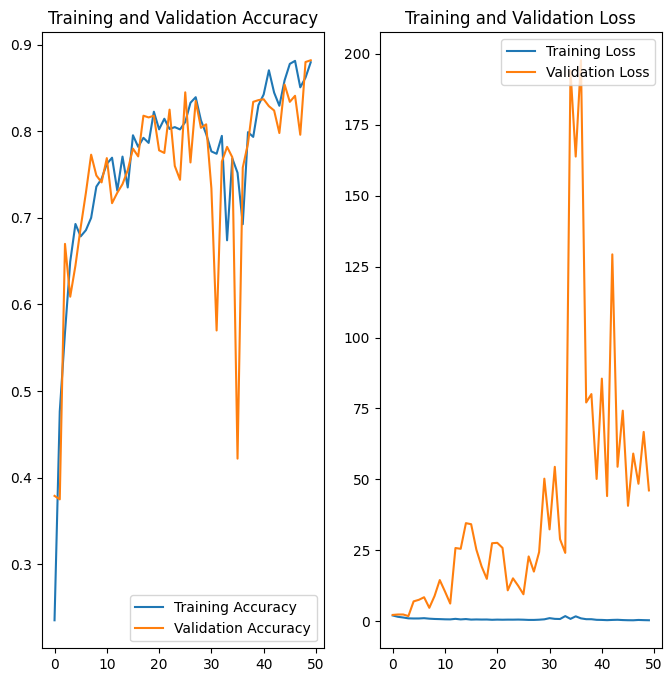

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

first image to predict
actual label: Tomato___Spider_mites Two-spotted_spider_mite
1/1 [==============================] - 0s 176ms/step
predicted label: Tomato___Spider_mites Two-spotted_spider_mite


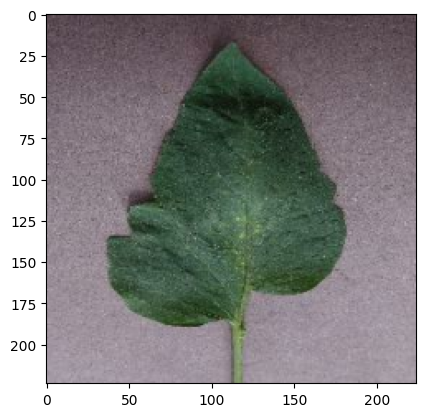

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])